# Classifiers and Class Labels

This notebook explores how the classification score visualizers handle constraints when it comes to different types of models, data, class labeling schemes, and other parameters. In particular we explore the following:

Target Types:

- binary
- multiclass (3 classes)

Target Encoding:

- integers
- labels 

Labeling:

- list of classes
- LabelEncoder
- dict encoding
- list of more classes than values in y

In [1]:
# Ensure we're importing the development version of Yellowbrick
import sys
sys.path.append("../..")

In [2]:
# Use inline so that we can run the notebook multiple times
%matplotlib inline

import matplotlib.pyplot as plt

# Import all of the Yellowbrick classifiers
from yellowbrick.classifier import *
from yellowbrick.exceptions import YellowbrickError
from yellowbrick.datasets import load_game, load_occupancy

# Import scikit-learn utilities
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from collections import namedtuple

Dataset = namedtuple("Dataset", "X,y,classes,encoder")
Split = namedtuple("Split", "train,test")

In [3]:
# Select the parameters to run against all models 
# Then restart kernel and run all
MODEL = MultinomialNB()
IS_FITTED = False
DATASET = "game" 
TARGET = "labels"
ENCODER = "dict"
USE_PANDAS = False


def make_dataset(name=DATASET, target=TARGET, encoder=ENCODER, use_pandas=USE_PANDAS):
    loader = {
        'game': load_game, 
        'occupancy': load_occupancy,
    }.get(name)
    
    dataset = loader(return_dataset=True)
    labels = sorted(dataset.meta['labels'].items(), key=lambda i: i[1])
    
    
    if use_pandas:
        X, y = dataset.to_pandas()
    else:
        X, y = dataset.to_numpy()
        
    if name == 'game':
        X = OneHotEncoder().fit_transform(X)
    
    # game target is string encoded, occupancy is integer encoded
    if target == "integers":
        if y.dtype.kind != 'i':
            y = LabelEncoder().fit_transform(y)
    elif target == "labels":
        if y.dtype.kind == 'i':
            rv = {i[1]: i[0] for i in labels.items()}
            y = np.array([rv[yi] for yi in y])
    else:
        raise ValueError(f"unknown target type '{target}', use integers or labels")
    
    c, le = None, None
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, shuffle=True, stratify=y)
    
    if encoder == 'list':
        c = [l[0] for l in labels]
    elif encoder == 'labelencoder':
        le = LabelEncoder().fit([l[0] for l in labels])
    elif encoder == 'dict':
        le = {l[1]: l[0] for l in labels}
    elif encoder is None:
        c, le = None, None
    else:
        raise ValueError(f"unknown encoder type '{encoder}', see make_dataset for choices")
    
    return Dataset(Split(X_train, X_test), Split(y_train, y_test), c, le)
    

def visualize(visualizer, model=MODEL, is_fitted=IS_FITTED, score=True):
    if is_fitted:
        # This includes both auto and True; fit the model manually if you want the exception raised
        model = model.fit(dataset.X.train, dataset.y.train)
    _, ax = plt.subplots(figsize=(9,6)) 
    
    try:
        oz = visualizer(model, ax=ax, classes=dataset.classes, encoder=dataset.encoder, is_fitted=is_fitted)
        oz.fit(dataset.X.train, dataset.y.train)

        if score:
            oz.score(dataset.X.test, dataset.y.test)

        oz.finalize()
    except YellowbrickError as e:
        print(e)
#     except Exception as e:
#         print("A NON YB ERROR OCCURRED:")
#         print(e)
    return oz
    
    
                         
dataset = make_dataset()

cannot encode class ''draw'' to label


ClassPredictionError(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x12d0765c0>,
                     classes=None, encoder={0: 'win', 1: 'loss', 2: 'draw'},
                     force_model=False, is_fitted=False, model=None)

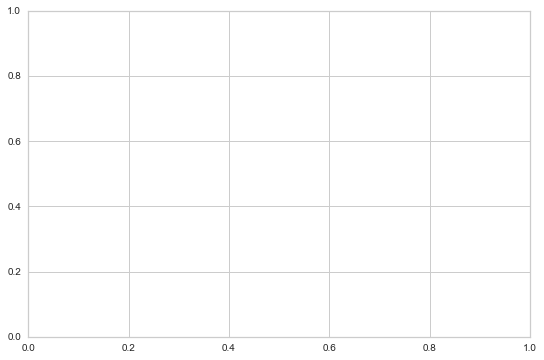

In [4]:
visualize(ClassPredictionError)

In [ ]:
visualize(ClassificationReport)

In [ ]:
visualize(ConfusionMatrix)

In [ ]:
visualize(PRCurve)

In [ ]:
visualize(ROCAUC)

In [ ]:
visualize(DiscriminationThreshold, score=False)

In [ ]:
dataset.encoder